In [1]:
import unidecode
import string
import random
import re
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
from fastDamerauLevenshtein import damerauLevenshtein

In [2]:
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('data.txt').read())
file_len = len(file)
print('file_len =', file_len)
all_characters

file_len = 1592


'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [3]:
data_split = file.splitlines()

In [4]:
#file2 = file.replace('\n','')
#file2

In [5]:
all_chars = ''.join(set(sorted(file)))
all_chars

'mdc\nIparngswzfxokbhet'

In [6]:
chunk_len = 300

In [7]:
def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [9]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

In [10]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [11]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [12]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, torch.LongTensor([target[c]]))

    loss.backward()
    decoder_optimizer.step()

    return loss.data / chunk_len

In [31]:
evaluate('\n', 1, temperature=0.4)

'\np'

### Prequential method

In [14]:
n_epochs = 300
print_every = 50
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('po', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 8s (50 16%) 1.6368]
pofkfsfg
pfksr
pskfbs
pocgwfkfkfkfks
pocogpbfsgkfkgr
wpwgfkso
pkfsagbkfs
gpsfsgcb
pwgfgkfsfkfr
pabscfk 

 17s (100 33%) 0.8471]
poc
wtgpkfsocr
pwkfg
cwgpowr
pocgw
pwogkfksr
cwpagbfkscb
pkfscga
pcsfksbagc
psfkgaca
pkfsgbac
pkfsbcga 

 26s (150 50%) 0.9064]
pococ
pocwkr
pwofkfksocr
pmck
pwocococreo
pwfksocr
pocgwpow
pocwksfkf
cpwgfkfsr
pwogfkswgre
pocopwg
pw 

 35s (200 66%) 0.6556]
pocwcfksfksr
pocwgfkf
perkscwgtf
pwgfkf
cpogskfr
pgcowprfkfks
pocopwgcowpgsfkf
pwgfkfk
pwgfksfk
gpwkf
 

 44s (250 83%) 0.3520]
poc
gwpfkf
gwpocopwg
pwogcopwgre
pocrfkfk
pocwkf
pgxfkf
gpwkf
copwg
powcgkfskfr
pwgkfs
gwopwgpcopocsfk 

 53s (300 100%) 0.6430]
pocwgkfs
pocgwptorekfksksg
pwocfksfksr
pwgerk
pwocfkskfr
gwpcopwgterkfswgre
ocwprkfsoc
pocgwrkfs
tgcwp 



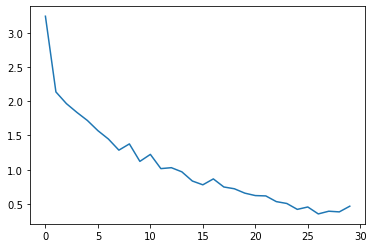

In [15]:
plt.figure()
plt.plot(all_losses)

In [32]:
results = [[] for line in data_split]
errors = [[] for x in data_split]

for line in range(0, len(data_split)):
    i = 0
    
    while i < len(data_split[line]):
        if i == 0:
            # generate prediction for first char (input: newline character)
            first_char = evaluate('\n', 1, temperature=0.4)
            predicted = first_char[1]
            observed = data_split[line][i]
            #print(predicted, observed)
            error = 1 - damerauLevenshtein(predicted, observed)
            errors[line].append(error)
            i += 1
            
        else:
            # generate prediction for next char (input: current char)
            next_char = evaluate(data_split[line][i-1], 1, temperature=0.4)
            predicted = next_char[1]
            observed = data_split[line][i]
            #print(predicted, observed)
            error = 1 - damerauLevenshtein(predicted, observed)
            errors[line].append(error)
            i += 1

In [23]:
errors

[[0.0, 0.0, 0.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0],
 [0.0, 1.0, 1.0, 0.0, 1.0],
 [0.0, 1.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 1.0, 1.0, 1.0],
 [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0

In [21]:
summed_error = [sum(error) for error in errors]
np.median(summed_error)

5.0

In [33]:
with open('results/pytorch_rnn_prequential_summed.txt', 'w') as f:
    f.write(str(summed_error))